# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [760]:
import pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [849]:
with open(r'D:\ucl\pyssem\scenario_properties_short.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)

In [769]:
# This is from 0, to length of the time period, with the time step being the time step defined by the user
time = scenario_properties.scen_times

# INITIAL POPULATION
# xo is the initial population, this shows for each orbital shell, the initial population
x0 = scenario_properties.x0

# LAUNCH RATE
# full lambda is the lambda value for the full time period
full_lambda = scenario_properties.full_lambda

# DRAG COEFFICIENT
# full_drag = scenario_properties.full_drag[:, 5]
# full_drag_lambda = []

# # Swap out the symbols for the actual values
# x, y = sp.symbols('x y')
# for i in range(len(full_drag)):
#     # Generate the current symbols to replace based on the expression's position in the list
#     sns_1 = sp.Symbol(f'N_6kg{i+1}')
#     sns_2 = sp.Symbol(f'N_6kg{i+2}')
    
#     expression = full_drag[i].subs({sns_1: x, sns_2: y})
    
#     # Update the list with the modified expression
#     full_drag_lambda.append(expression) 

# full_drag_updated_lambda = [sp.lambdify((x, y), eq, 'numpy') for eq in full_drag_lambda]

#Symbols
symbols = scenario_properties.species_types
print(symbols)

# Initial population
print(x0)

# Lambda function
print(full_lambda[0])

# POST MISSION DISPOSAL
full_pmd = scenario_properties.full_Cdot_PMD
symbols = full_pmd.atoms(sp.Symbol)
print(full_pmd[:, 1])

full_coll = scenario_properties.equations
print(full_coll[:, 1])

drag = scenario_properties.full_drag
print(drag[:, 1])

[]
         Su_260kg  Su_473kg  sns  N_0.00141372kg  N_0.567kg  N_6kg  N_260kg  \
alt_bin                                                                       
0             2.0         0    0             0.0          0      0        0   
1             2.0         0    0             0.0          0      0        0   
2            11.0         0    0             0.0          0      0        0   
3            14.0         0    0             0.0          0      0        0   
4            30.0         0    0             0.0          0      0        0   
5            43.0         0    0             0.0          0      0        0   
6            44.0         0    0             0.0          0      0        0   
7           117.0         0    0             0.0          0      0        0   
8           161.0         0    0             0.0          0      0        0   
9           212.0         0    0             1.0          0      0        0   
10          265.0         0    0             0.0 

In [816]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

        
# Convert to symbols
print(len(symbols)) # Should be 320 for a 40, 8 matrix
print(symbols)
# Convert equations to lambda functions
equations = [sp.lambdify(symbols, eq, 'numpy') for eq in scenario_properties.equations]

320
[Su_260kg_1, Su_260kg_2, Su_260kg_3, Su_260kg_4, Su_260kg_5, Su_260kg_6, Su_260kg_7, Su_260kg_8, Su_260kg_9, Su_260kg_10, Su_260kg_11, Su_260kg_12, Su_260kg_13, Su_260kg_14, Su_260kg_15, Su_260kg_16, Su_260kg_17, Su_260kg_18, Su_260kg_19, Su_260kg_20, Su_260kg_21, Su_260kg_22, Su_260kg_23, Su_260kg_24, Su_260kg_25, Su_260kg_26, Su_260kg_27, Su_260kg_28, Su_260kg_29, Su_260kg_30, Su_260kg_31, Su_260kg_32, Su_260kg_33, Su_260kg_34, Su_260kg_35, Su_260kg_36, Su_260kg_37, Su_260kg_38, Su_260kg_39, Su_260kg_40, Su_473kg_1, Su_473kg_2, Su_473kg_3, Su_473kg_4, Su_473kg_5, Su_473kg_6, Su_473kg_7, Su_473kg_8, Su_473kg_9, Su_473kg_10, Su_473kg_11, Su_473kg_12, Su_473kg_13, Su_473kg_14, Su_473kg_15, Su_473kg_16, Su_473kg_17, Su_473kg_18, Su_473kg_19, Su_473kg_20, Su_473kg_21, Su_473kg_22, Su_473kg_23, Su_473kg_24, Su_473kg_25, Su_473kg_26, Su_473kg_27, Su_473kg_28, Su_473kg_29, Su_473kg_30, Su_473kg_31, Su_473kg_32, Su_473kg_33, Su_473kg_34, Su_473kg_35, Su_473kg_36, Su_473kg_37, Su_473kg_38,

In [800]:
full_lambda_flattened = []

for i in range(len(full_lambda)):
    if full_lambda[i] is not None:
        full_lambda_flattened.extend(full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [825]:
x0_flattened = x0.T.values.flatten()
equations[6](*x0_flattened)

0.0875

In [833]:
print(scenario_properties.equations[0])

outcome = equations[0](*x0_flattened)
print(outcome)

-1.04894741604327e-8*pi*N_0p00141372kg_1*Su_260kg_1 - 1.42472603142352e-8*pi*N_0p567kg_1*Su_260kg_1 - 4.0828598495625e-8*pi*N_260kg_1*Su_260kg_1 - 1.51592799913287e-7*pi*N_473kg_1*Su_260kg_1 - 1.33813040872173e-8*pi*N_6kg_1*Su_260kg_1 - 8.16571969912501e-18*pi*Su_260kg_1**2 - 1.51592799913287e-17*pi*Su_260kg_1*Su_473kg_1 - 1.33813040872173e-13*pi*Su_260kg_1*sns_1 - 0.125*Su_260kg_1
-0.2500000000000001


In [851]:
# Initial population needs to be in one columnn, so now the intiial population is in one. Species 1 is the first 40 rows, species 2 is the next 40 rows, etc.
def population_shell(t, N, full_lambda, equations):
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)
    
    # Iterate over each component in N
    for i in range(len(N)):
        # Compute the intrinsic rate of change from the differential equation
        dN_dt[i] = equations[i](*N)
        
        # Compute and add the external modification rate, if applicable
        lambda_value = full_lambda[i]
        if lambda_value is not None:
            # Add the lambda_value's contribution to the rate of change
            # Assume lambda_value is a function of time t
            dN_dt[i] += lambda_value(t)
           
    return dN_dt
    
output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, args=(full_lambda_flattened, equations), t_eval=scenario_properties.scen_times, method='RK23')    

In [626]:
def satellite_ode(t, N, rate_of_change, full_drag, full_pmd):
    # Assuming rate_of_change is a callable that represents your interpolated rate of change function
    # N is going to be each shells current count of the number of satellites
    out = []
    
    # First we need to calculate the rate of change for each shell
    for i in range(len(N)):  # Adjust loop to avoid out-of-bounds
        
        # Calculate launch rate (input)
        r = rate_of_change[i](t)

        # Number of satellites decaying into the shell below
        sats_curr = N[i]
        try:
            sats_upp = N[i+1] # Number of satellites coming from the shell above
        except IndexError:
            sats_upp = 0 # Top shell
        
        # Now evaluate each lambdified drag equation
        drag_value = full_drag[i](sats_curr, sats_upp)

        # Post mission disposal
        pmd_value = full_pmd[i](sats_curr)

        out.append(r + drag_value + pmd_value)

    return out


# # Solve the system of ODEs
sol = solve_ivp(satellite_ode, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0, 
                args=(full_lambda, full_drag_updated_lambda, full_pmd_lambda), 
                t_eval=scenario_properties.scen_times, method='RK23')

# Plotting the results
plt.figure(figsize=(10, 6))

for i in range(sol.y.shape[0]):
    plt.plot(sol.t, sol.y[i], label=f'Shell {i+1}')

plt.xlabel('Time')
plt.ylabel('Number of Satellites')
plt.title('Satellite Population Dynamics')
plt.legend()
plt.show()


TypeError: Cannot convert expression to float

D:\TEMP\ipykernel_9284\3150393037.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


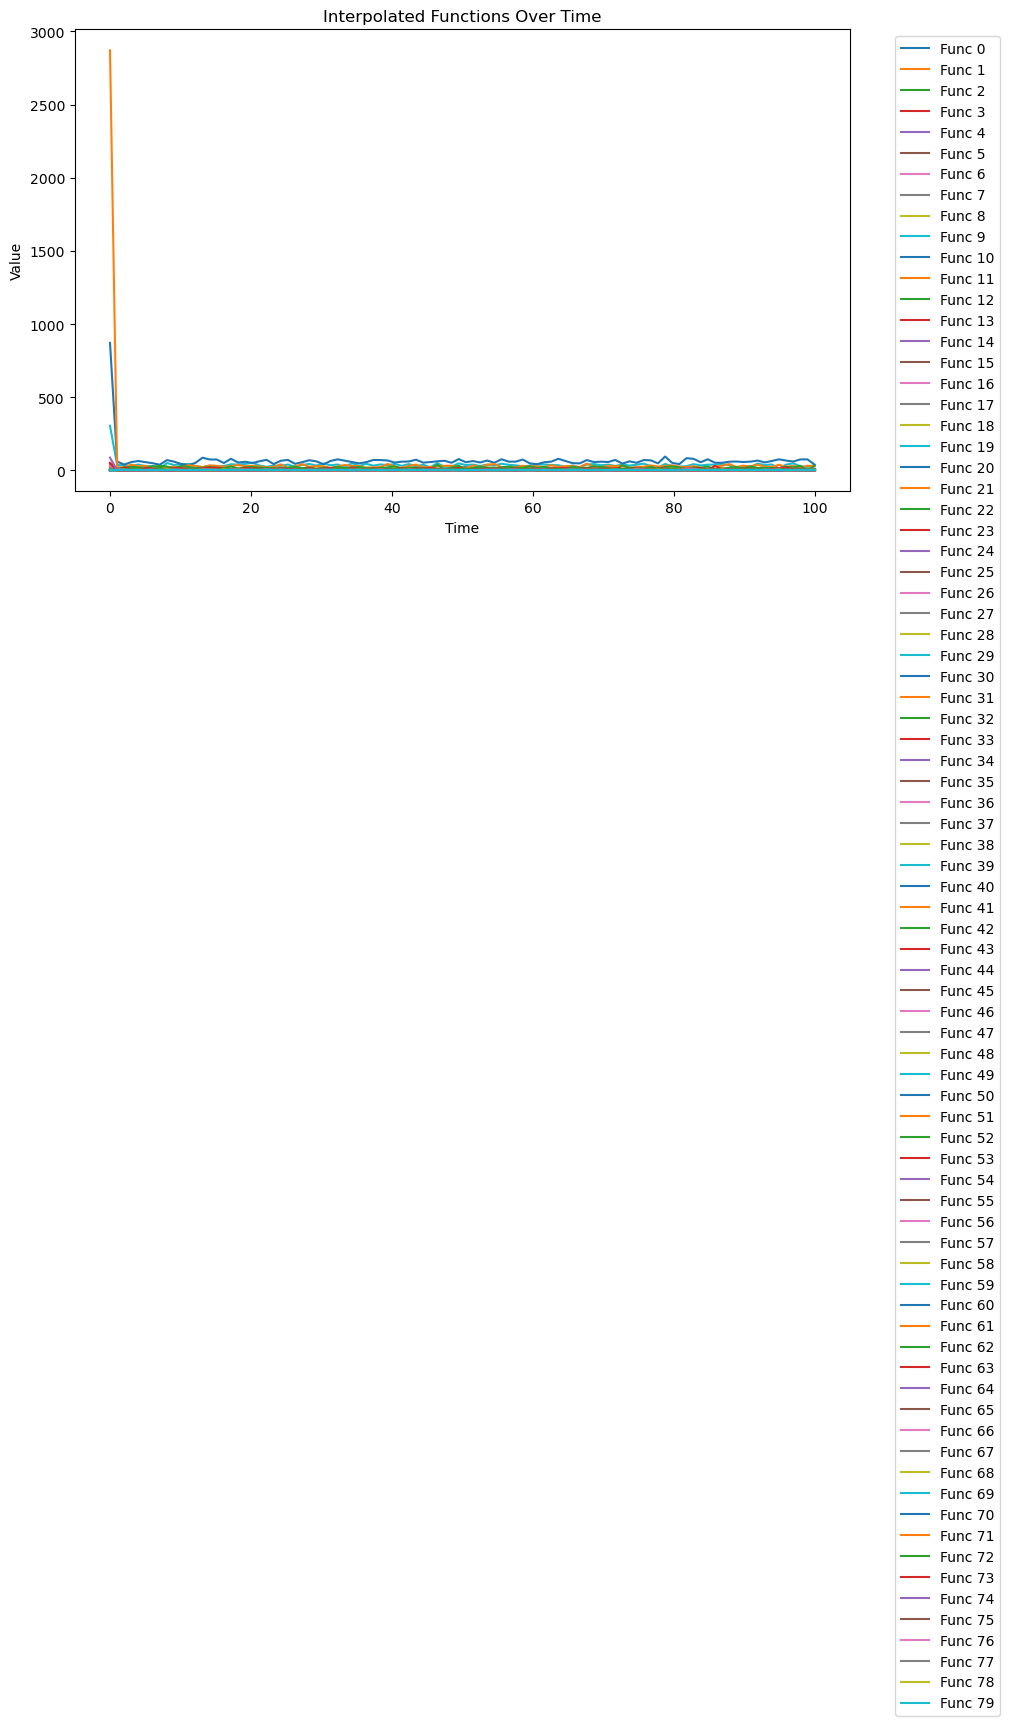

In [850]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.scen_times defines the time range for plotting
start_time, end_time = scenario_properties.scen_times[0], scenario_properties.scen_times[-1]
time_points = np.linspace(start_time, end_time, 100)  # Adjust the number of points as necessary

# Filter out None values from the list of interpolated functions
interpolated_functions = [f for f in full_lambda_flattened if f is not None]

# Plot each interpolated function
plt.figure(figsize=(10, 6))
for func in interpolated_functions:
    # Evaluate the function at each point in time_points
    values = func(time_points)
    
    # Plot the result
    plt.plot(time_points, values)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Interpolated Functions Over Time')
plt.legend([f'Func {i}' for i, _ in enumerate(interpolated_functions)], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()